<a href="https://colab.research.google.com/github/DanielKorenDataScience/ClassificationProject/blob/main/Classification_Project_Shufersal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification Project

for Shufersal on-line orders, for replacing of missing products, will predict the replacement success!

In [20]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
p = print
d = display

# Get Data

## Raw Data

To run the raw section, one must load Sweets_ver2.csv to local google drive and change the next line to True

In [21]:
RAW = False

In [22]:
def get_raw(fname):
  data_url = 'https://github.com/DanielKorenDataScience/ClassificationProject/blob/main/' + fname + '.csv?raw=true'
  resp = requests.get(data_url)
  text = resp.text
  
  with open(fname + '.csv', 'w') as fh:
    fh.write(text)

In [23]:
def diff_list(li1, li2):
  return [i for i in li1 + li2 if i not in li1 or i not in li2]

In [24]:
if RAW:    
  df1 = pd.read_csv('/content/drive/MyDrive/Sweets_ver2.csv', encoding='ISO-8859-8', nrows=1)
  df2 = pd.read_csv('/content/drive/MyDrive/Sweets_ver2.csv', encoding='ISO-8859-8', usecols=[i for i in range(82) if not i in[0,8,10,12,14,16,18,20,24,26,27,48,50,52,54,56,58,62,64,65]])

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
if RAW:
  df1.info()

Eliminating unwanted columns - mostly descriptive columns

In [27]:
if RAW:
  d(diff_list(list(df1.columns), list(df2.columns)))

In [28]:
if RAW:
  d(df2.info())

In [29]:
# Fix Typo mistake
if RAW: 
  df2.rename(columns={'OrderNumbert': 'OrderNumber','BrandIndDescSuss': 'BrandIndDescSubs', 'ProductNumberSubs': 'ParentProductNumberSubs', 
                    'NetSaleNoVatPrdSubs': 'NetSaleNoVatPrdLast3MonthsSubs', 'CafiotSucarSusb': 'CafiotSucarSubs'}, inplace=True)

Eliminating nulls

In [30]:
# Fill na
if RAW:
  df2.fillna({'QuantSale': 1, 'QuantSaleSubs': 1}, inplace=True)
  df2.fillna(0, inplace=True)
  d(df2.info())

In [31]:
if RAW:
  df2.to_csv("Shufersal.csv", index = False)
  p(df2.shape)

In [32]:
if RAW:
  df = pd.read_csv('Shufersal.csv', index_col=False)
  p(df.shape)

## Encoding categories

In [33]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

if RAW:
  enc.fit(['noPromo', 'PromoSusbSamePromo', 'PromoSusbDiffPromo'])
  p(df.isPromo.value_counts())
  p()
  df.isPromo = enc.transform(df.isPromo)
  p(df.isPromo.value_counts())

In [34]:
if RAW:
  for col in ['LocationCityName', 'PeriodHoliday', 'BrandIndDesc', 'BrandName', 'BrandIndDescSubs', 'BrandNameSubs']:
    p(col)
    p(pd.DataFrame(df[col].value_counts()).index)
    df[col] = enc.fit_transform(df[col])
    p(pd.DataFrame(df[col].value_counts()).index)

## Calc diff vector

In [35]:
if RAW:
  df.columns

In [36]:
if RAW:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', 'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar', 'QuantSale', 'cntMonths', 'DiscountPerUnit']:
    df[col + 'Diff'] = df[col] - df[col + 'Subs']

In [37]:
if RAW:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', 'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
    df[col + 'Diff'] = (df[col + 'Diff'] != 0)
    df[col + 'Diff'] = enc.fit_transform(df[col + 'Diff'])

## Use Dummies

Minimal improvement - FalseNegative (0,0) improved from 1338 to 1328

In [38]:
## Converting the categories column (isPromo) to dummies column 
if RAW:
  p(df.shape)
  df = pd.get_dummies(df, columns=['isPromo', 'PeriodHoliday'])
  p(df.shape)

In [39]:
if RAW:
  df.to_csv("Shufersal_with_diff.csv", index = False)

In [40]:
if RAW:
  df = pd.read_csv('Shufersal_with_diff.csv', index_col=False)
  p(df.shape)

In [41]:
if RAW:
  d(df.head())

# Get ready Data

In [42]:
if not RAW:
  get_raw('Shufersal_with_diff')

In [43]:
if not RAW:
  df = pd.read_csv('Shufersal_with_diff.csv', encoding='ISO-8859-8')
  p(df.shape)
  df.head()

(54460, 89)


# Models

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X = df.drop('CorrelateItemStatusCode', axis=1)
y = df.CorrelateItemStatusCode.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math

pd.set_option("precision", 2)
df_result = pd.DataFrame()

In [46]:
def report_old(clf, X, y, data_type='Test'):
  p()
  p(type(clf).__name__ + ': ' + data_type)
  p('_____________________________________________________')
  acc = accuracy_score(y_true=y, y_pred=clf.predict(X))
  cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=clf.predict(X)),
                    index=clf.classes_,
                    columns=clf.classes_)
  d(cm)
  rep = classification_report(y_true=y, y_pred=clf.predict(X), zero_division=1, output_dict=True)
  rep =  pd.DataFrame(rep)
  rep.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1, inplace=True)
  rep = rep.T
  rep['accuracy'] = acc
  rep.support = rep.support.astype(int)
  cols = list(rep.columns[:3]) + ['accuracy', 'support']
  rep = rep[cols]
  d(rep)
  return

In [47]:
def report(clf, X, y, data_type='Test'):
  global df_result
  name = type(clf).__name__ + ': ' + data_type
  acc = accuracy_score(y_true=y, y_pred=clf.predict(X))
  index = [(name, clf.classes_[0]), (name, clf.classes_[1])]
  cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=clf.predict(X)),
                    index=clf.classes_,
                    columns=clf.classes_)
  cm.reset_index(drop=True, inplace=True)
  rep = classification_report(y_true=y, y_pred=clf.predict(X), zero_division=1, output_dict=True)
  rep =  pd.DataFrame(rep)
  rep.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1, inplace=True)
  rep = rep.T
  rep['accuracy'] = acc
  rep.support = rep.support.astype(int)
  cols = list(rep.columns[:3]) + ['accuracy', 'support']
  rep = rep[cols]
  rep['precision_avg'] = rep.precision.mean()
  rep['recall_avg'] = rep.recall.mean()
  rep['f1-score_avg'] = rep['f1-score'].mean()
  rep.reset_index(drop=True, inplace=True)
  df = cm.join(rep)
  df['name'] = name
  df.reset_index(inplace=True)
  #df.set_index(['name', 'index'], inplace=True)
  df_result.reset_index(inplace=True)
  df_result = df_result.append(df, ignore_index=True)
  df_result.set_index(['name', 'index'], inplace=True)
  #d(df_result)
  return

In [48]:
def showFeatureImportance(model, X_train=X_train, threshold=0):
  if type(model).__name__ == 'LogisticRegression':  # no features importance data
    w0 = model.intercept_[0]
    w = model.coef_[0]
    fx_imp = pd.Series(w, index=X_train.columns)
  else:
    fx_imp = pd.Series(model.feature_importances_, index=X_train.columns)
  fx_imp /= fx_imp.sum()
  fx_imp = fx_imp.sort_values()
  fx_imp = fx_imp[fx_imp > threshold]
  fig = plt.figure(figsize=(5,5))
  plt.xlim(0, 1)
  fx_imp.plot(kind='barh', title=type(model).__name__ )

In [49]:
def process_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot=False, threshold=0):
  p('running: ', type(model).__name__)
  model.fit(X_train, y_train)
  report(model, X_train, y_train, 'Train')
  report(model, X_test, y_test)
  if plot:
    showFeatureImportance(model, X_train, threshold) 

In [50]:
from sklearn.linear_model import LogisticRegression, BayesianRidge, Lasso, Ridge
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

running:  LogisticRegression
running:  LogisticRegression
running:  GradientBoostingClassifier
running:  AdaBoostClassifier
running:  AdaBoostClassifier
running:  RandomForestClassifier
running:  RandomForestClassifier
running:  KNeighborsClassifier


0  ...  f1-score_avg
name                              index           ...              
LogisticRegression: Train         0          0.0  ...          0.40
                                  1          0.0  ...          0.40
LogisticRegression: Test          0          0.0  ...          0.40
                                  1          0.0  ...          0.40
LogisticRegression: Train         0          0.0  ...          0.40
                                  1          0.0  ...          0.40
LogisticRegression: Test          0          0.0  ...          0.40
                                  1          0.0  ...          0.40
GradientBoostingClassifier: Train 0       7929.0  ...          0.79
                                  1       2101.0  ...          0.79
GradientBoostingClassifier: Test  0       3409.0  ...          0.78
                                  1        957.0  ...          0.78
AdaBoostClassifier: Train         0       7794.0  ...          0.76
                                  1       2735.0  ...          0.76
AdaBoostClassifier: Test          0       3334.0  ...          0.76
                                  1       1212.0  ...          0.76
AdaBoostClassifier: Train         0       7278.0  ...          0.76
                                  1       2129.0  ...          0.76
AdaBoostClassifier: Test          0       3121.0  ...          0.76
                                  1        953.0  ...          0.76
RandomForestClassifier: Train     0      12648.0  ...          1.00
                                  1          0.0  ...          1.00
RandomForestClassifier: Test      0       4059.0  ...          0.83
                                  1       1010.0  ...          0.83
RandomForestClassifier: Train     0      11811.0  ...          0.97
                                  1        166.0  ...          0.97
RandomForestClassifier: Test      0       4051.0  ...          0.84
                                  1        913.0  ...          0.84
KNeighborsClassifier: Train       0       3754.0  ...          0.60
                                  1       2490.0  ...          0.60
KNeighborsClassifier: Test        0       1519.0  ...          0.58
                                  1       1197.0  ...          0.58

[32 rows x 10 columns]

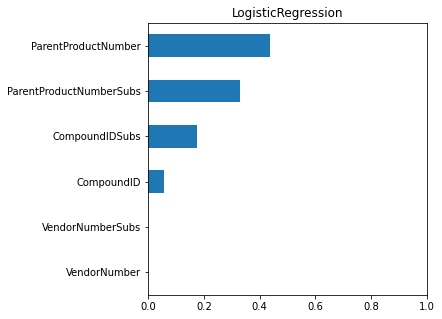

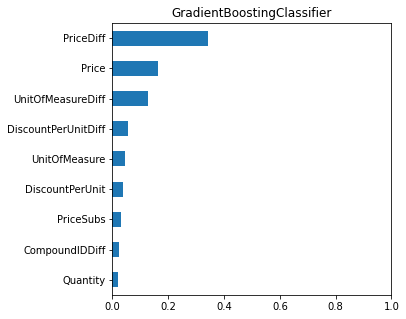

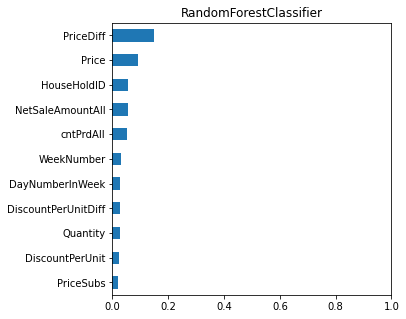

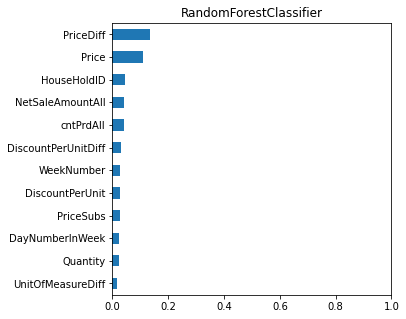

In [51]:
df_result = pd.DataFrame()

process_model(LogisticRegression(max_iter=1000), threshold=0.0000005)  # did not fit, return accuracy=0, so we increased max_iter from default 100
process_model(LogisticRegression(C=100, max_iter=1000, fit_intercept=False, warm_start=True), threshold=0.0000005, plot=True)
process_model(GradientBoostingClassifier(n_estimators=100), plot=True, threshold=0.015)
process_model(AdaBoostClassifier(n_estimators=100))  # base estimator is DecisionTreeClassifier initialized with max_depth=1
process_model(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.01))
process_model(RandomForestClassifier(n_estimators=64), plot=True, threshold=0.015)
process_model(RandomForestClassifier(n_estimators=500, min_samples_split=6, criterion='entropy'), plot=True, threshold=0.015)
process_model(KNeighborsClassifier(n_neighbors=39))

if False: # ERROR: Classification metrics can't handle a mix of binary and continuous targets
  process_model(GradientBoostingRegressor(n_estimators=100, max_depth=5))
  process_model(BayesianRidge())
  process_model(Lasso())
  process_model(Ridge(alpha = 0.5))
if False: ## too long > 4 minutes
  process_model(LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=0.1, max_iter=20000)) # max_iter increaed from default 1000 to 3000, 6000, 20000 because did not coverged warning
  from sklearn import svm
  process_model(svm.SVC())
  process_model(svm.SVR())

d(df_result)

## Grid Search for hyperparameters - on best model RandonForest

In [52]:
GS = False
if GS:
  clf_RF = RandomForestClassifier(n_estimators=64)
  clf_RF.fit(X_train, y_train)
  p(clf_RF.score(X_train, y_train))
  p(clf_RF.score(X_test, y_test))

In [53]:
if GS:
  param_grid = { 
  #    'max_depth' : [None, 4,5,6,7,8],
      'n_estimators': [64, 200, 500],
      'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['gini', 'entropy'], 
      'max_leaf_nodes': [None, 4, 10, 20],
      'min_samples_split': [2, 4, 6, 8, 10, 12, 14]
  }
  param_grid0 = { 
    'max_depth' : [None, 4,5,6,7,8],   # done seperately - result is None
  }

  clf_RF = RandomForestClassifier()
  clf_gs = GridSearchCV(clf_RF, param_grid, cv=5, verbose=4)
  clf_gs.fit(X_train, y_train)

  p('Results')
  clf_gs.estimator
  p(clf_gs.best_params_)
  p(clf_gs.best_estimator_)

In [54]:
if GS:
  p(clf_gs.score(X_train, y_train))
  p(clf_gs.score(X_test, y_test))

# TODO:

## cross validation

In [55]:
if False:
  
  from sklearn.ensemble import VotingClassifier

  process_model(VotingClassifier(estimators=[('GBR', model1), ('BR', model2), ('KNN', model3)], voting='soft'))

## run a model with the important feature alone to show is it a must or just necessary (if the drop in precision is large it is not a must)?

## Bagging (Bootstrap Aggregation)

> One classifier ("base model") and try to fit many different subsamples of the data

> The hyper-parameters "max_samples" and "max_features" control the size of the subsets

> The hyper-parameters "bootstrap" and "bootstrap_features" control wether the samples and the features are drawn with (or without) replacement

In [56]:
clf_base = DecisionTreeClassifier(max_depth=5)

In [57]:
clf_bagging = BaggingClassifier(base_estimator=clf_base, n_estimators=50)
clf_bagging.fit(X_train, y_train)

clf_bagging.score(X_train, y_train)
clf_bagging.score(X_test, y_test)

0.7863875627371771

## Correlation